In [1]:
import pandas as pd
import numpy as np
import pandas.api.types as ptypes
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image, display
from dowhy import CausalModel

pd.set_option('max_columns', None)

### Ecommerce Sales Causation Inference
Problem Statement:

The data contains checkout data and relevant user information for an e-commerce platform. Using the data provided we are trying to answer the following questions:
  1. What factors contribute to users making a purchase? Provide at least the top 2 contributing factors and calculate their potential impact
  2. What factors contribute to users generating higher basket amounts? Provide at least the top 2 contributing factors and calculate their potential impact

#### Load the data

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df

,user_id,is_new,time,voucher_type,voucher_valid,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
0,281605921,1,2015-06-12 03:41:44.263000+00:00,NaN,NaN,0.000029,0.0000,0.0,0.00,0.000000,0,0,0,0,0,0,0,tier_2,0,0,0,0,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619
1,281605921,1,2015-06-15 04:11:26.177000+00:00,NaN,NaN,0.000024,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,0,tier_2,0,0,0,0,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619
2,125302602,0,2015-04-24 14:07:48.720000+00:00,NaN,NaN,0.000164,0.0000,0.0,0.00,0.000000,0,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
3,125302602,0,2015-05-04 01:05:09.518000+00:00,1.0,1.0,0.000175,0.0002,1.0,0.01,0.019864,1,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
4,125302602,0,2015-05-15 11:18:25.739000+00:00,1.0,1.0,0.000170,0.0002,1.0,0.01,0.019324,1,1,1,1,0,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229842,123299082,0,2015-05-24 08:01:40.917000+00:00,NaN,NaN,0.000008,0.0000,0.0,0.00,0.000000,1,1,1,0,4,1,2,tier_2,0,1,0,2,2013-07-14 01:53:12+00:00,1,0.113160,0.000764,0.020270,0.290323,0.001524,0.009238,0.034430,0.155847
229843,124128885,0,2015-04-12 05:27:18.913000+00:00,NaN,NaN,0.000175,0.0000,0.0,0.00,0.000000,0,1,1,1,0,1,2,tier_1,0,1,0,1,2013-07-15 04:27:35+00:00,1,0.005423,0.006373,0.006757,0.064516,0.000053,0.009238,0.034120,0.160492
229844,124432258,0,2015-04-14 07:41:30.031000+00:00,NaN,NaN,0.000060,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,3,tier_1,0,0,0,0,2013-07-15 20:52:43+00:00,0,0.001085,0.028134,0.000000,0.096774,0.000006,0.000000,0.033245,0.155760
229845,124611908,0,2015-05-29 07:24:39.461000+00:00,NaN,NaN,0.000009,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,2,tier_1,0,1,0,1,2013-07-16 09:11:11+00:00,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619


We are going to assume that 0 is for False/No, and 1 is for True/Yes

In [4]:
df_initial = df.copy()

# 1. Explore the data

In [5]:
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['time'] = pd.to_datetime(df_initial['time'])
df_initial['account_created_at'] = pd.to_datetime(df_initial['account_created_at'])

# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

# show first lines
display(df_initial[:5])

Dataframe dimensions: (229847, 32)


,user_id,is_new,time,voucher_type,voucher_valid,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
column type,int64,int64,"datetime64[ns, UTC]",float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,"datetime64[ns, UTC]",int64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,190889,187866,0,0,0,0,0,0,0,0,0,0,0,0,776,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,83.0505,81.7352,0,0,0,0,0,0,0,0,0,0,0,0,0.337616,0,0,0,0,0,0,0,0,0,0,0,0,0,0


,user_id,is_new,time,voucher_type,voucher_valid,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
0,281605921,1,2015-06-12 03:41:44.263000+00:00,NaN,NaN,0.000029,0.0000,0.0,0.00,0.000000,0,0,0,0,0,0,0,tier_2,0,0,0,0,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.00000,0.000000,0.033242,0.155619
1,281605921,1,2015-06-15 04:11:26.177000+00:00,NaN,NaN,0.000024,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,0,tier_2,0,0,0,0,2014-03-23 04:01:30+00:00,0,0.004158,0.001420,0.000000,0.000000,0.00000,0.000000,0.033242,0.155619
2,125302602,0,2015-04-24 14:07:48.720000+00:00,NaN,NaN,0.000164,0.0000,0.0,0.00,0.000000,0,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703
3,125302602,0,2015-05-04 01:05:09.518000+00:00,1.0,1.0,0.000175,0.0002,1.0,0.01,0.019864,1,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703
4,125302602,0,2015-05-15 11:18:25.739000+00:00,1.0,1.0,0.000170,0.0002,1.0,0.01,0.019324,1,1,1,1,0,1,1,tier_2,1,1,0,1,2013-07-18 07:24:40+00:00,1,0.016450,0.004848,0.006757,0.225806,0.00009,0.016166,0.033882,0.157703


In [6]:
#Change to datetime

df_initial['account_created_at'] = df_initial['account_created_at'].dt.date
df_initial['time'] = df_initial['time'].dt.date

df_initial['time'] = pd.to_datetime(df_initial['time'])
df_initial['account_created_at'] = pd.to_datetime(df_initial['account_created_at'])

Many voucher_type and voucher_valid feature have large missing value. We will drop this column because the missing value is too large

In [7]:
del df_initial['voucher_type']
del df_initial['voucher_valid']

In [8]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,user_id,is_new,time,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
column type,int64,int64,datetime64[ns],float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,datetime64[ns],int64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,776,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.337616,0,0,0,0,0,0,0,0,0,0,0,0,0,0


marketing_tier feature have a small amount of missing value. We will drop this missing value

In [9]:
df_initial.dropna(axis = 0, subset = ['marketing_tier'], inplace = True)

In [10]:
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

,user_id,is_new,time,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
column type,int64,int64,datetime64[ns],float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,object,int64,int64,int64,int64,datetime64[ns],int64,float64,float64,float64,float64,float64,float64,float64,float64
null values (nb),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_initial

,user_id,is_new,time,basket_amount,voucher_max_amount,voucher_percentage,voucher_min_purchase,voucher_amount,trx_is_voucher,is_paid,is_remitted,user_purchased_prior,num_voucher_errors,purchase,province,marketing_tier,user_type,user_group,account_type,referrer_type,account_created_at,user_register_from,sessions,average_session_length,num_visit_promo_page,num_product_types,num_trx,num_trx_voucher,gmv,aov
0,281605921,1,2015-06-12,0.000029,0.0000,0.0,0.00,0.000000,0,0,0,0,0,0,0,tier_2,0,0,0,0,2014-03-23,0,0.004158,0.001420,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619
1,281605921,1,2015-06-15,0.000024,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,0,tier_2,0,0,0,0,2014-03-23,0,0.004158,0.001420,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619
2,125302602,0,2015-04-24,0.000164,0.0000,0.0,0.00,0.000000,0,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
3,125302602,0,2015-05-04,0.000175,0.0002,1.0,0.01,0.019864,1,1,1,1,6,1,1,tier_2,1,1,0,1,2013-07-18,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
4,125302602,0,2015-05-15,0.000170,0.0002,1.0,0.01,0.019324,1,1,1,1,0,1,1,tier_2,1,1,0,1,2013-07-18,1,0.016450,0.004848,0.006757,0.225806,0.000090,0.016166,0.033882,0.157703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229842,123299082,0,2015-05-24,0.000008,0.0000,0.0,0.00,0.000000,1,1,1,0,4,1,2,tier_2,0,1,0,2,2013-07-14,1,0.113160,0.000764,0.020270,0.290323,0.001524,0.009238,0.034430,0.155847
229843,124128885,0,2015-04-12,0.000175,0.0000,0.0,0.00,0.000000,0,1,1,1,0,1,2,tier_1,0,1,0,1,2013-07-15,1,0.005423,0.006373,0.006757,0.064516,0.000053,0.009238,0.034120,0.160492
229844,124432258,0,2015-04-14,0.000060,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,3,tier_1,0,0,0,0,2013-07-15,0,0.001085,0.028134,0.000000,0.096774,0.000006,0.000000,0.033245,0.155760
229845,124611908,0,2015-05-29,0.000009,0.0000,0.0,0.00,0.000000,0,1,1,0,0,1,2,tier_1,0,1,0,1,2013-07-16,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033242,0.155619


#### Yeay no more missing values

### Detecting duplicates

In [11]:
print('Duplicate value: {}'.format(df_initial.duplicated().sum()))

Duplicate value: 1041


In [12]:
df_initial.drop_duplicates(keep='first', inplace=True)

In [13]:
print('Duplicate value: {}'.format(df_initial.duplicated().sum()))

Duplicate value: 0


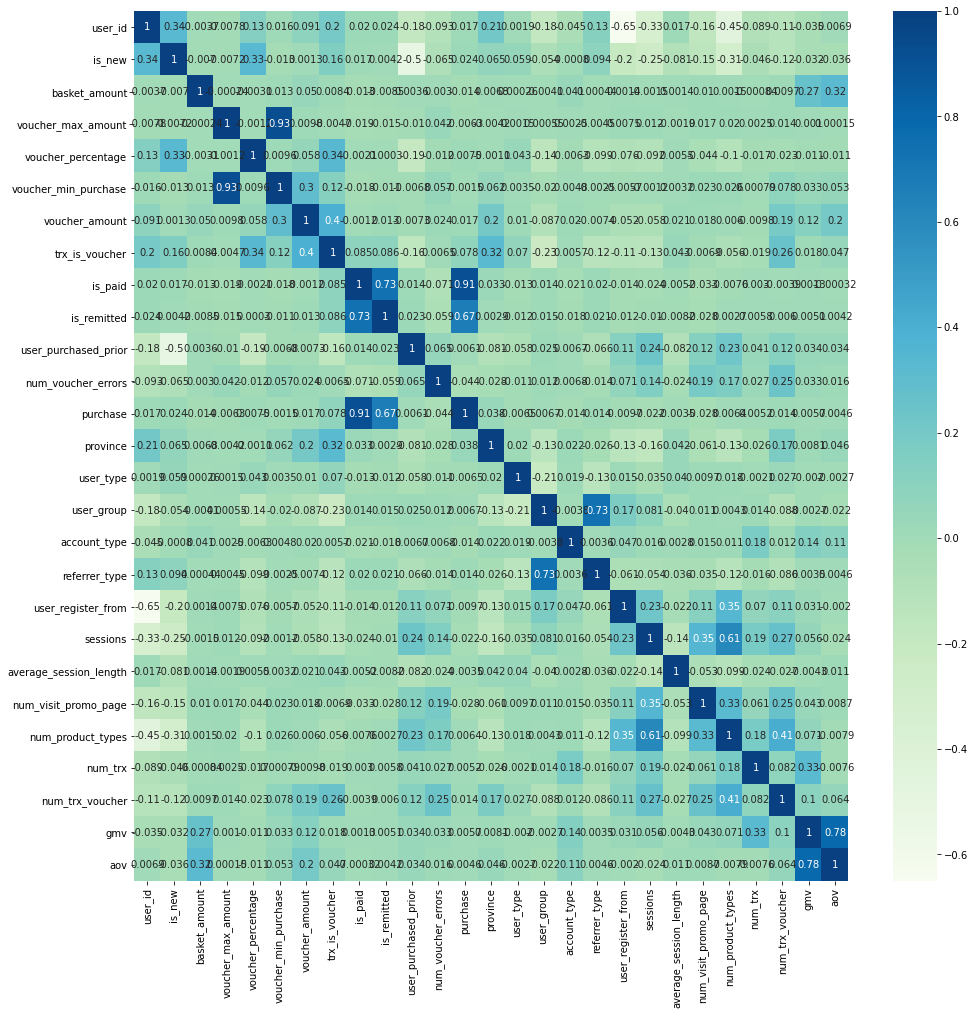

In [16]:
correlation = df_initial.corr()

plt.figure(figsize = (16,16))

ax = sns.heatmap(correlation, annot=True, cmap = 'GnBu')

In [17]:
def corrFilter(bound: float):
    xFiltered = correlation[((correlation >= bound) | (correlation <= -bound)) & (correlation !=1.000)]
    xFlattened = xFiltered.unstack().sort_values().drop_duplicates()
    return xFlattened

corrFilter(.7)

user_group          referrer_type           0.729818
is_paid             is_remitted             0.734730
gmv                 aov                     0.782725
is_paid             purchase                0.912444
voucher_max_amount  voucher_min_purchase    0.925980
user_id             user_id                      NaN
dtype: float64

# 2. EDA

We will plot several features to see the connection between the features in the data.

#### The thing to keep in mind is that correlation in data may or may not be the cause of why the data is like that. The causation inference will be done in the next step

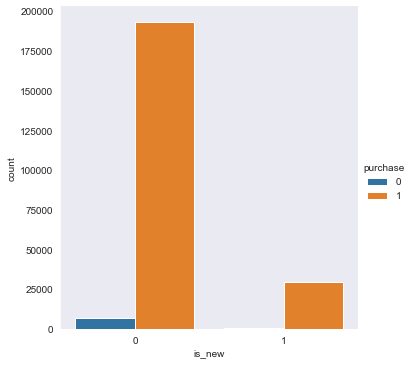

In [12]:
sns.catplot(x='is_new', kind='count', hue='purchase', data=df_initial)

<AxesSubplot:xlabel='is_new'>

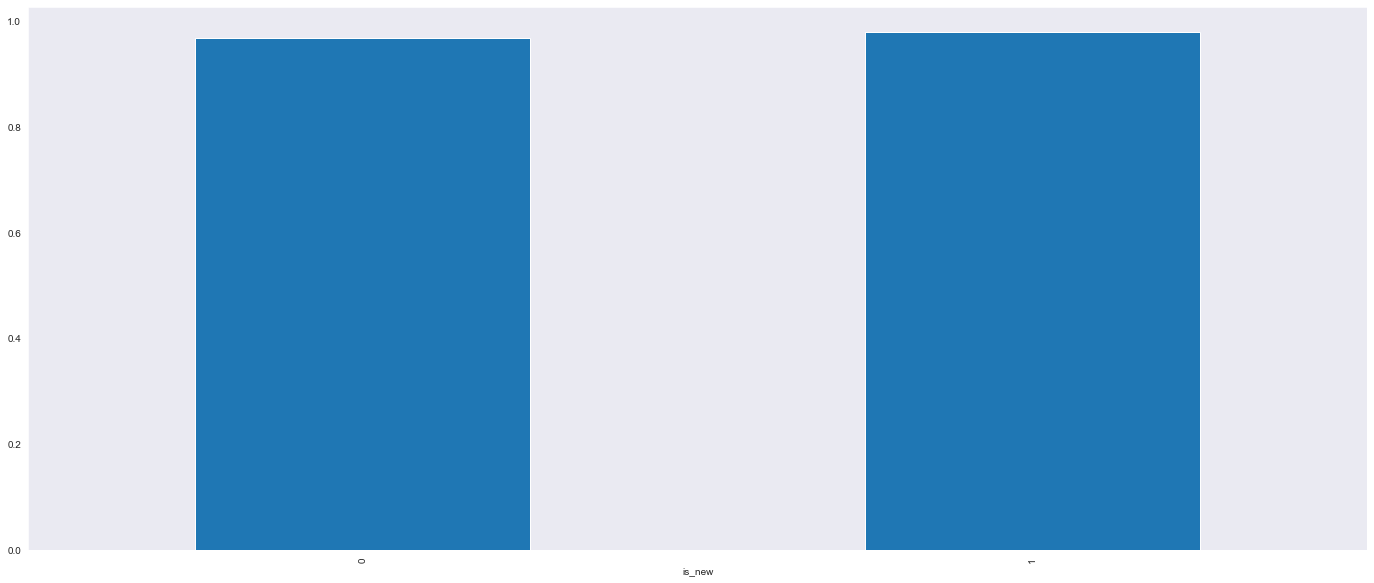

In [13]:
df_initial.groupby('is_new', as_index=True)['purchase'].mean().plot(kind='bar')

Here we can see that the new and old customer have the same number of purchase average, so there is no difference in number of purchase, whether it is from new or old customer

In [10]:
df_temp1 = df_initial[df_initial['purchase']==1].groupby('province', as_index=False)['purchase'].count()
df_temp2 = df_initial[df_initial['trx_is_voucher']==1].groupby('province', as_index=False)['trx_is_voucher'].count()
df_merged = pd.merge(df_temp1, df_temp2, how='outer', on=['province'])

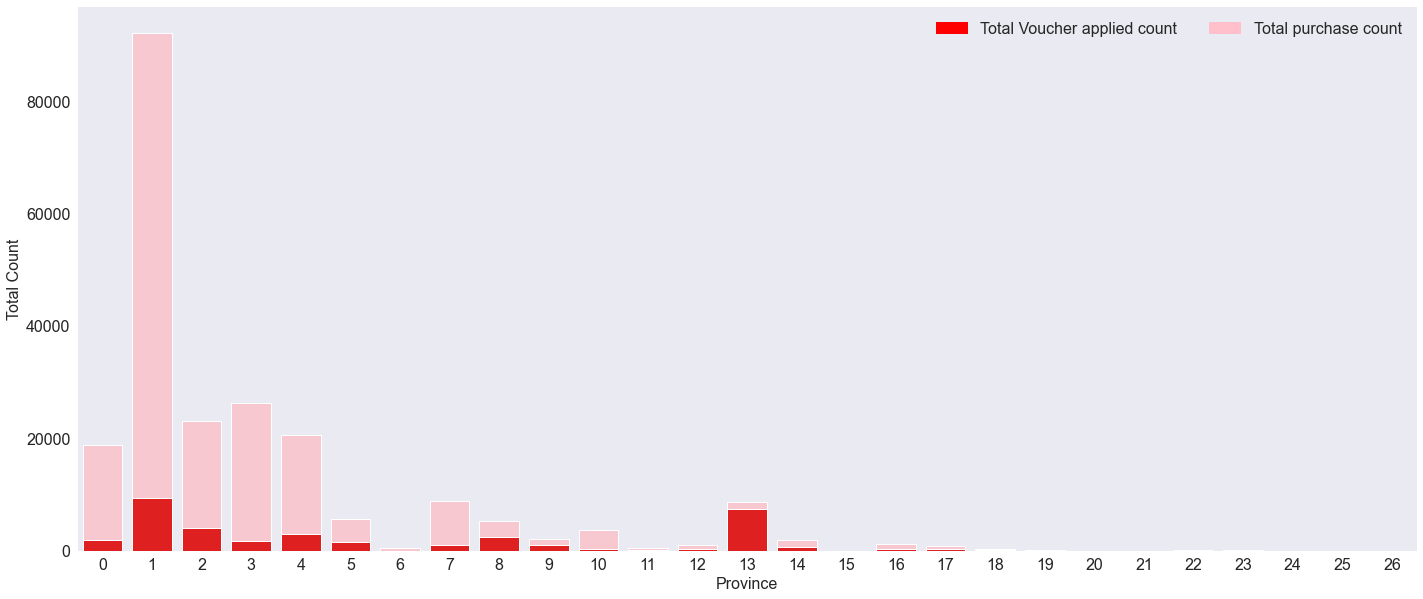

In [11]:
sns.set_context({'figure.figsize':(24,10)})
sns.set_style('dark')

sns.barplot(x='province', y='purchase', data=df_merged, color='pink')
bottom_plot = sns.barplot(x='province', y='trx_is_voucher', data=df_merged, color='red')

topbar = plt.Rectangle((0,0),1,1,fc='pink', edgecolor='none')
bottombar = plt.Rectangle((0,0),1,1,fc='red', edgecolor='none')
l = plt.legend([bottombar, topbar], ['Total Voucher applied count','Total purchase count'], loc=1, ncol=2, prop={'size':16})
l.draw_frame(False)

sns.despine(left=True, bottom=True)
bottom_plot.set_ylabel('Total Count')
bottom_plot.set_xlabel('Province')

for item in ([bottom_plot.xaxis.label, bottom_plot.yaxis.label] + bottom_plot.get_xticklabels() + bottom_plot.get_yticklabels()):
    item.set_fontsize(16)

1. Province 1 has the highest total count of purchase
2. Province 13 has the highest ratio between voucher applied count and total purchase count

<!-- 1. Province no.1 have the highest purchase using voucher count
2. Province no.13 have the highest ratio of voucher usage in purchase
3. All of the provinces except No.13 is more likely to not using voucher when purchasing -->

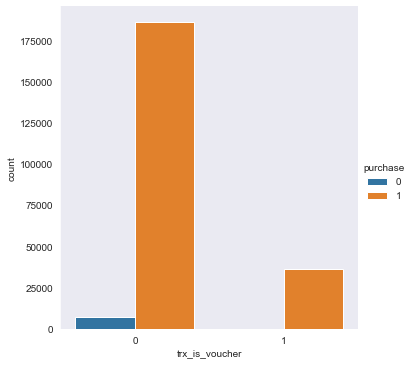

In [14]:
sns.catplot(x='trx_is_voucher', kind='count', hue='purchase', data=df_initial)

Here we can see that customers are more likely to not use voucher when purchasing. Although, customers who is using vouchers will decide to purchase the product.

<AxesSubplot:xlabel='marketing_tier'>

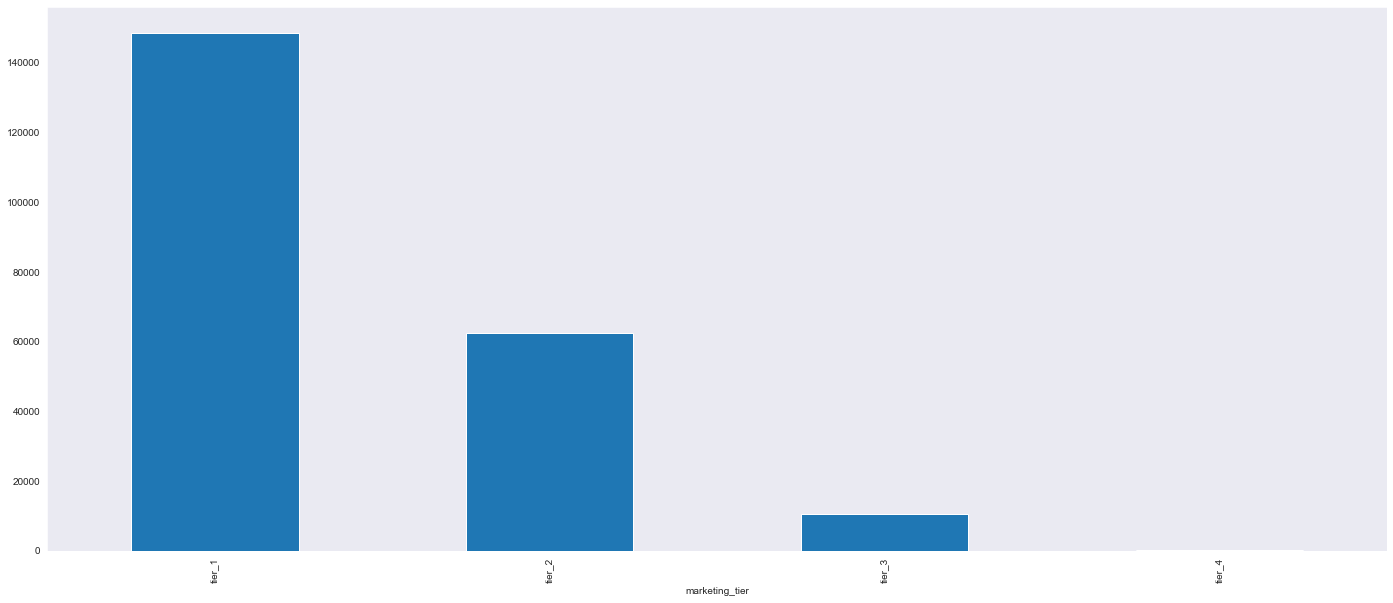

In [15]:
df_initial[(df_initial['purchase']==1)].groupby('marketing_tier', as_index=True)['purchase'].count().plot(kind='bar')

Tier 1 have the highest purchase count

<AxesSubplot:xlabel='purchase', ylabel='num_trx'>

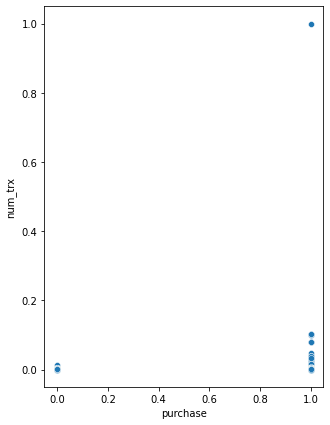

In [15]:
sns.set_context({'figure.figsize':(5,7)})
sns.scatterplot(data=df_initial, x='purchase', y='num_trx')

<AxesSubplot:xlabel='purchase', ylabel='num_trx'>

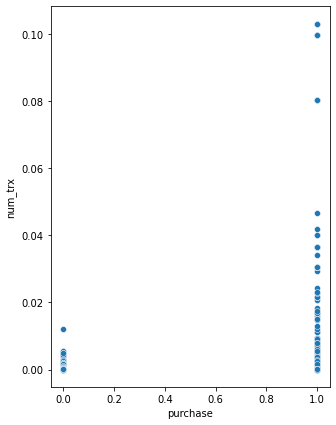

In [16]:
df_temp = df_initial[df_initial['num_trx']<0.6]

sns.scatterplot(data=df_temp, x='purchase', y='num_trx')

As we can see from scatter plot, customer who purchase tend to have higher amount of number of transaction

<AxesSubplot:xlabel='purchase', ylabel='voucher_min_purchase'>

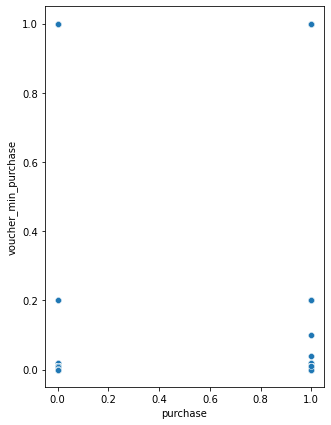

In [17]:
sns.scatterplot(data=df_initial, x='purchase', y='voucher_min_purchase')

<AxesSubplot:xlabel='purchase', ylabel='voucher_min_purchase'>

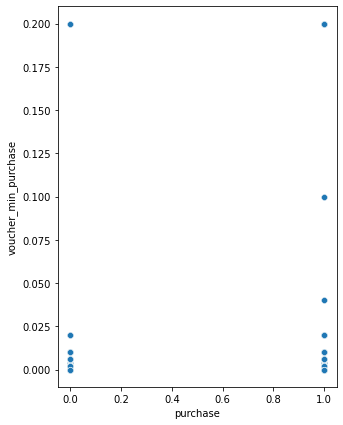

In [18]:
df_temp = df_initial[df_initial['voucher_min_purchase']<0.5]

sns.scatterplot(data=df_temp, x='purchase', y='voucher_min_purchase')

<AxesSubplot:xlabel='purchase'>

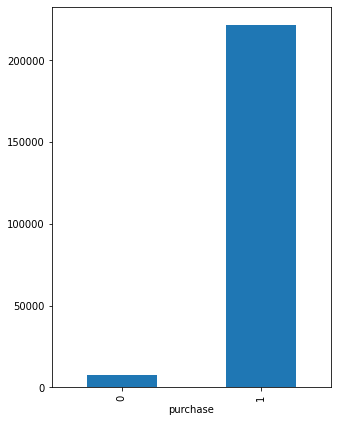

In [19]:
df_temp.groupby('purchase')['voucher_min_purchase'].count().plot(kind='bar')

<AxesSubplot:xlabel='purchase'>

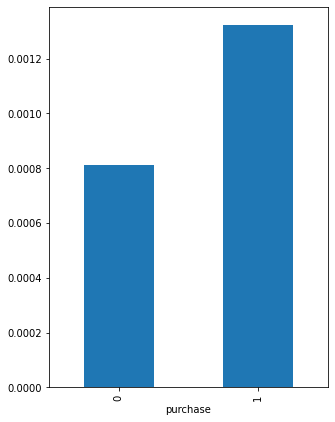

In [20]:
df_temp.groupby('purchase')['voucher_min_purchase'].mean().plot(kind='bar')

From the plots above, voucher_min_purchase can lead to purchase

<AxesSubplot:xlabel='account_created_at'>

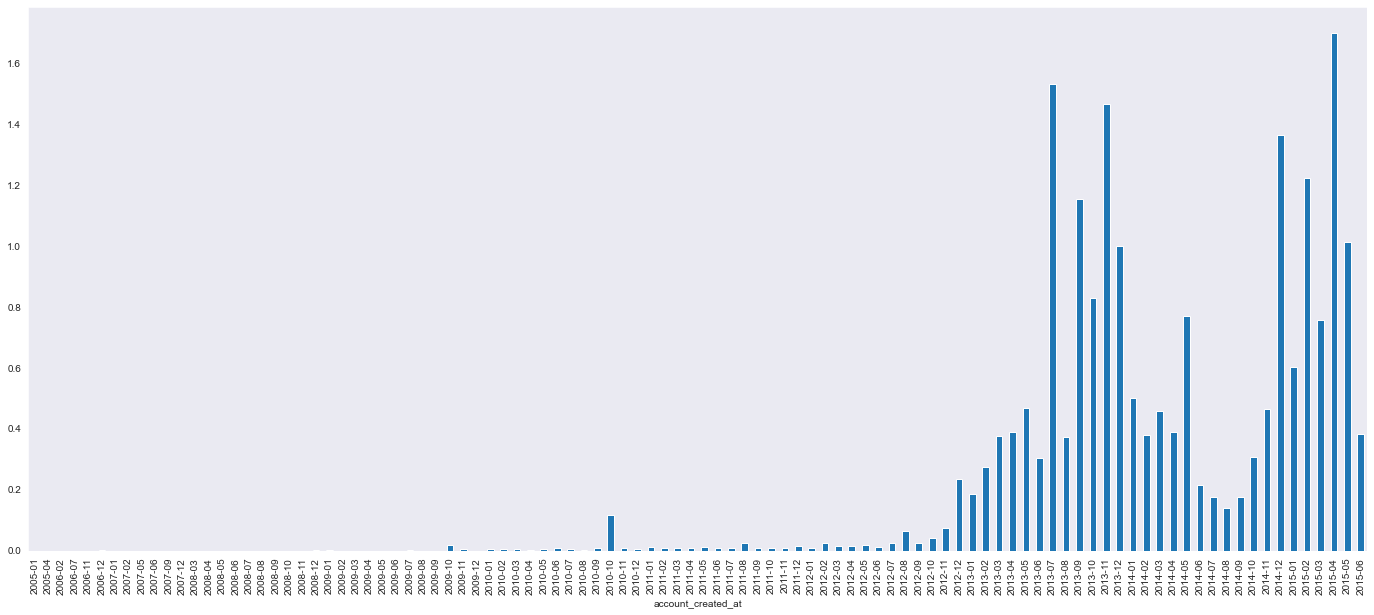

In [22]:
df_initial.groupby(df_initial['account_created_at'].dt.to_period('m'), as_index=True)['basket_amount'].sum().plot(kind='bar')

<AxesSubplot:xlabel='account_created_at'>

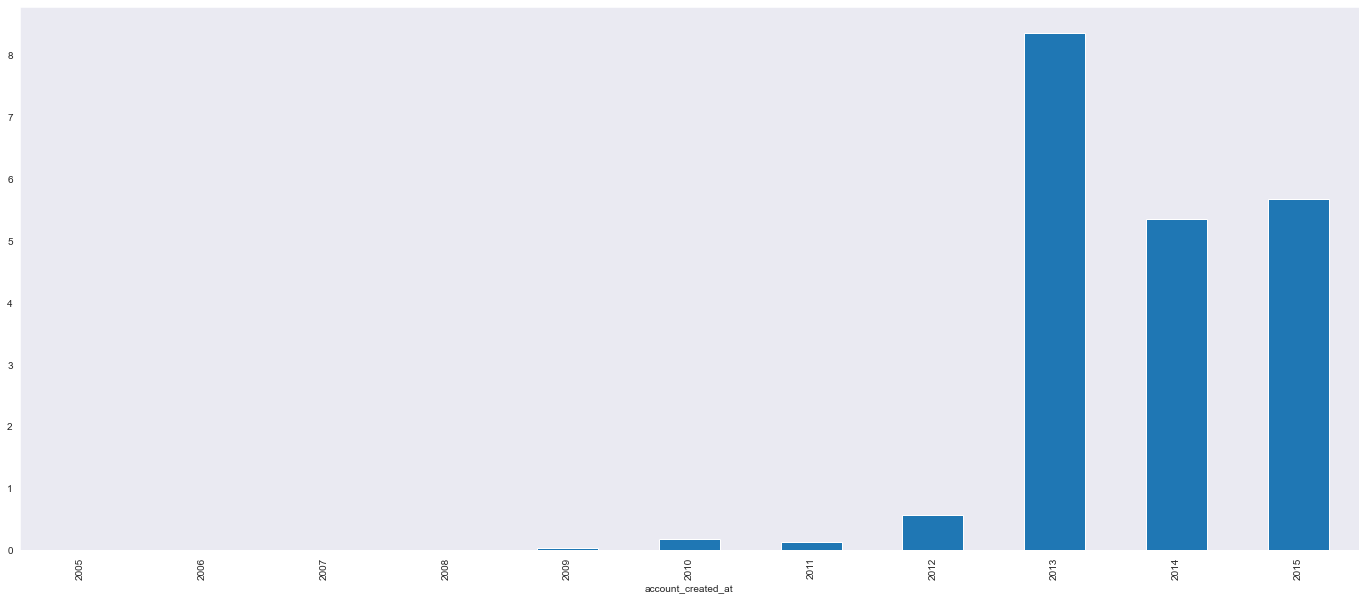

In [23]:
df_initial.groupby(df_initial['account_created_at'].dt.to_period('Y'), as_index=True)['basket_amount'].sum().plot(kind='bar')

<AxesSubplot:xlabel='account_created_at'>

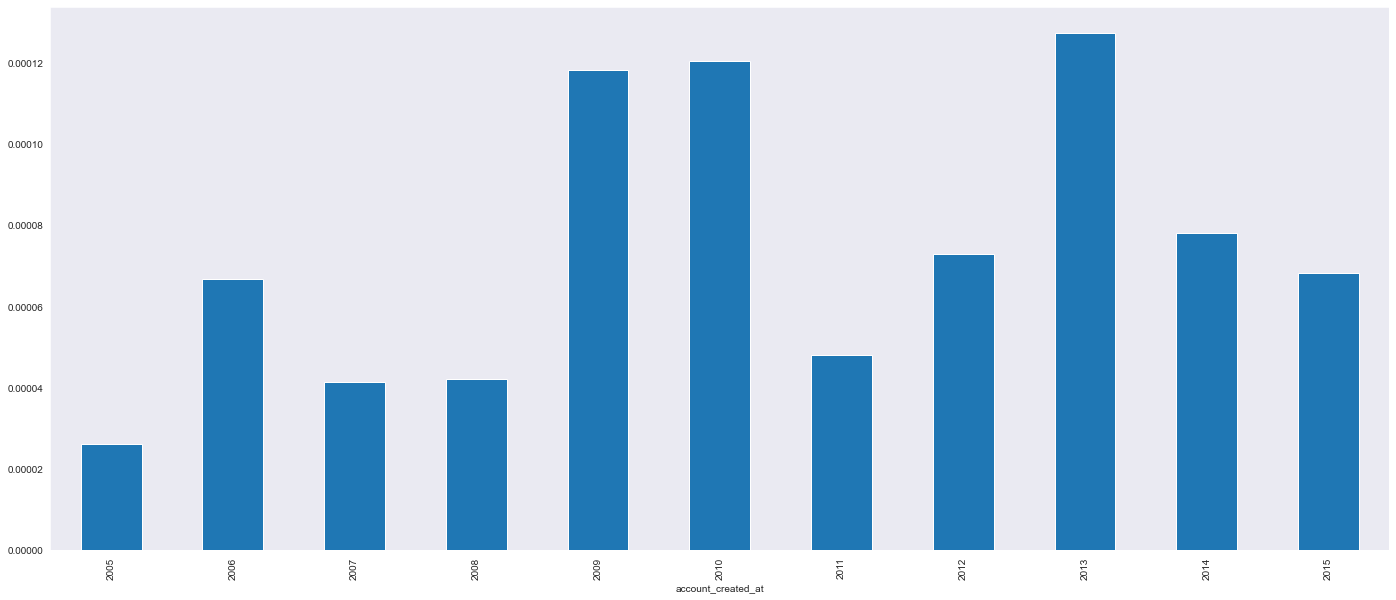

In [24]:
df_initial.groupby(df_initial['account_created_at'].dt.to_period('Y'), as_index=True)['basket_amount'].mean().plot(kind='bar')

Account created at 2013 have higher basket amount count and average than any year

<AxesSubplot:xlabel='trx_is_voucher', ylabel='basket_amount'>

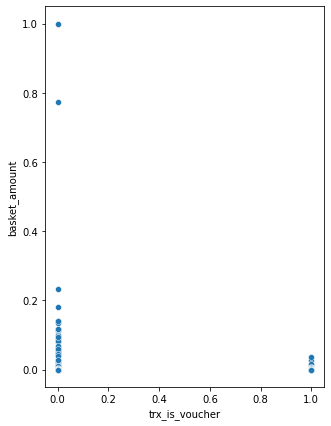

In [21]:
sns.scatterplot(data=df_temp, x='trx_is_voucher', y='basket_amount')

From the plot above, customer who is not using voucher have higher basket amount

<AxesSubplot:xlabel='user_purchased_prior', ylabel='basket_amount'>

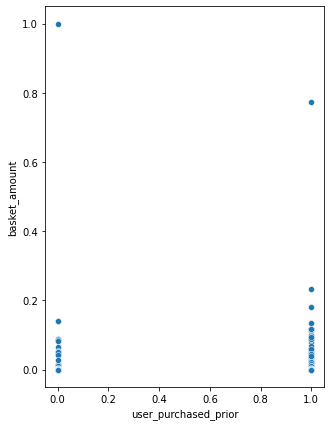

In [22]:
sns.scatterplot(data=df_temp, x='user_purchased_prior', y='basket_amount')

From the plot above, customer who have purchased prior to the event have higher basket amount

<AxesSubplot:xlabel='purchase', ylabel='basket_amount'>

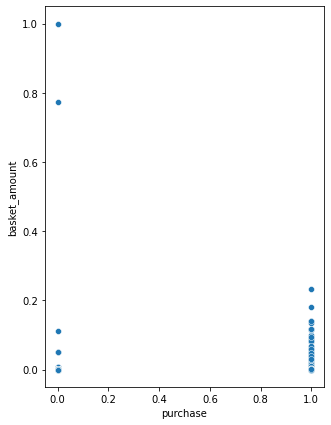

In [23]:
sns.scatterplot(data=df_temp, x='purchase', y='basket_amount')

From the plot above, customer who purchase tend to have higher basket amount

<AxesSubplot:xlabel='province'>

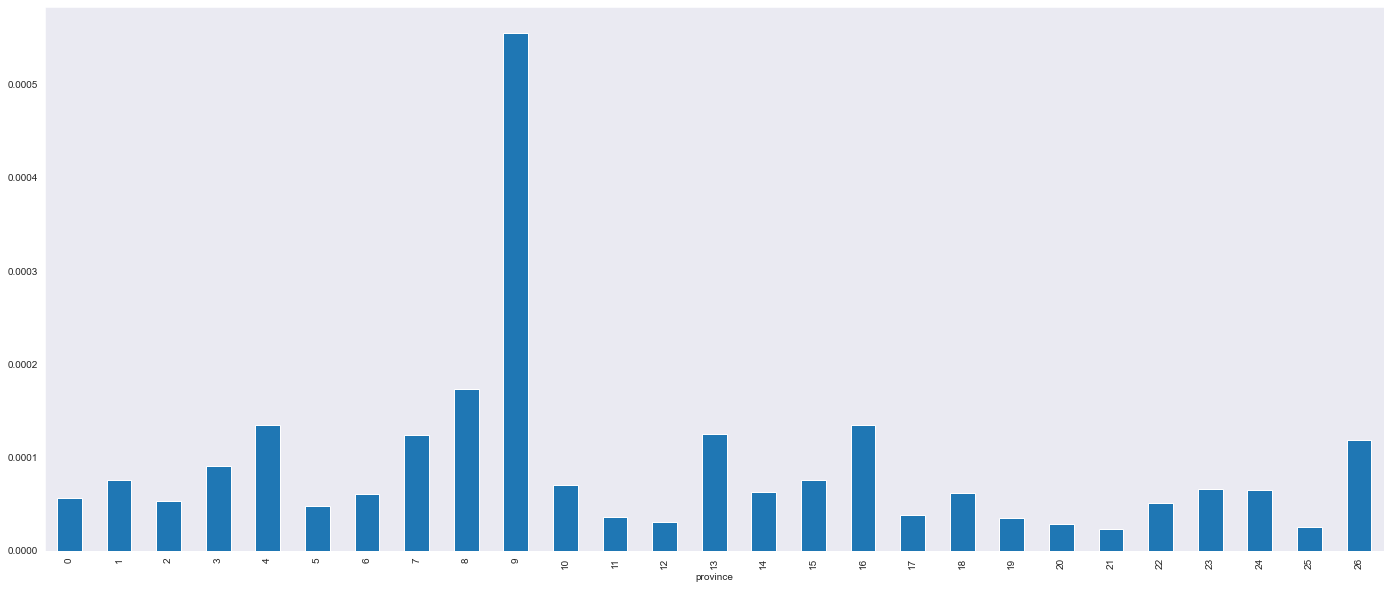

In [28]:
df_temp.groupby('province')['basket_amount'].mean().plot(kind='bar')

From the plot above, customer who is in province 9, on average have higher basket amount

<AxesSubplot:xlabel='marketing_tier', ylabel='basket_amount'>

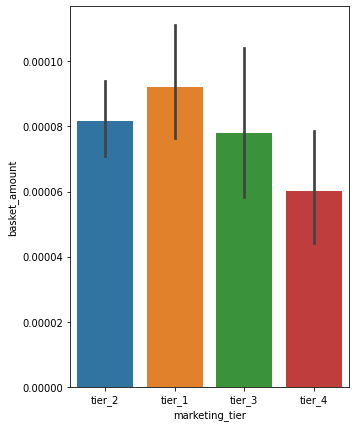

In [24]:
sns.barplot(data=df_initial, x='marketing_tier', y='basket_amount')

Customer who is in tier 1 tend to have higher basket amount than any marketing tier

# 3. DoWhy

Despite the hype around AI, most Machine Learning (ML)-based projects focus on predicting outcomes rather than understanding causality. Indeed, after several projects, I realized that ML is great at finding correlations in data, but not causation. In our projects, we try to not fall into the trap of equating correlation with causation.

Even though we can observe correlation, it does not prove causation.

##### Causality: influence by which one event, process or state, a cause, contributes to the production of another event, process or state, an effect, where the cause is partly responsible for the effect, and the effect is partly dependent on the cause.

Much like machine learning libraries have done for prediction, "DoWhy" is a Python library that aims to spark causal thinking and analysis. DoWhy provides a principled four-step interface for causal inference that focuses on explicitly modeling causal assumptions and validating them as much as possible. The key feature of DoWhy is its state-of-the-art refutation API that can automatically test causal assumptions for any estimation method, thus making inference more robust and accessible to non-experts. 

### Question:

1. What factors contribute to users making purchase? Provide top 2 contributing factors and calculate their potential impact
2. What factors contribute to users generating higher basket amount? Provide top 2 contributing factors and calculate their potential impact

In [16]:
df_initial['purchase_1'] = df_initial['purchase'].apply(lambda x: True if x == 1 else False)

In [17]:
training = df_initial[['purchase_1','is_new','basket_amount',
                      'trx_is_voucher','user_purchased_prior','sessions',
                      'average_session_length','num_trx','num_trx_voucher',
                      'gmv','aov','num_visit_promo_page',
                      'voucher_max_amount','voucher_percentage','voucher_min_purchase',
                      'voucher_amount','num_voucher_errors']].copy()

We will only be using features shown above

In [18]:
#Creating the causal graph
causal_graph = """
digraph {
is_new;
basket_amount;
trx_is_voucher;
user_purchased_prior;
purchase_1;
sessions;
average_session_length;
num_trx;
num_trx_voucher;
gmv;
aov;
num_visit_promo_page;
voucher_max_amount;
voucher_percentage;
voucher_min_purchase;
voucher_amount;
num_voucher_errors;
U[label="Unobserved Confounders"];

is_new -> purchase_1; 
basket_amount -> purchase_1; 
trx_is_voucher->purchase_1;
user_purchased_prior -> gmv;
user_purchased_prior -> aov;
user_purchased_prior -> num_trx;
user_purchased_prior -> sessions;
user_purchased_prior -> num_visit_promo_page;
user_purchased_prior -> basket_amount;
sessions -> average_session_length;
average_session_length -> purchase_1;
num_visit_promo_page -> trx_is_voucher;
num_visit_promo_page -> num_trx_voucher;
num_trx -> purchase_1;
num_trx_voucher -> trx_is_voucher;
voucher_max_amount-> trx_is_voucher;
voucher_percentage-> trx_is_voucher;
voucher_min_purchase-> trx_is_voucher;
voucher_amount-> trx_is_voucher;
num_voucher_errors-> trx_is_voucher;
gmv -> purchase_1;
gmv -> basket_amount;
aov -> purchase_1;
aov -> basket_amount;
U->purchase_1;
U->trx_is_voucher;
U->basket_amount;
U->is_new;
U->user_purchased_prior;
U->gmv;
U->aov;
U->num_trx;
U->sessions;
U->average_session_length;
U->num_visit_promo_page;
U->num_trx_voucher;
U->voucher_max_amount;
U->voucher_percentage;
U->voucher_min_purchase;
U->voucher_amount;
U->num_voucher_errors;
}
"""

On the code above, we create the causation graph.
#### This is based solely on my limited knowledge and assumptions. DoWhy algorithm is expected to see the causational linkage between the feature that I have missed

## 3.1 Contributing factors on Purchase

In [105]:
feat_1 = []
est_1 = []

for col in training:
    if col != 'purchase_1':
        feat_1.append(str(col))
        df_result = pd.DataFrame(feat_1)
        
        model= CausalModel(
                data = training,
                graph=causal_graph.replace("\n", " "),
                treatment=col,
                outcome='purchase_1')
        
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
        
        est_1.append(str(estimate.value))
        df_result['estimated_impact'] = est_1

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['is_new'] on outcome ['purchase_1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
INFO:dowhy.causal_estimator:b: purchase_1~is_new+num_voucher_errors+num_trx+basket_amount+average_session_length+user_purchased_prior+num_trx_voucher+trx_is_voucher+num_visit_promo_page+gmv+voucher_percentage+voucher_min_purchase+sessions+voucher_amount+voucher_max_amount+aov+is_new*average_session_length+is_new*user_purchased_prior+is_new*num_trx_voucher+is_new*trx_is_voucher+is_new*num_visit_promo_page+is_new*num_voucher_errors+is_new*num_trx+is_new*gmv+is_new*voucher_percentage+is_new*vouc

Code above will loop through all of the selected features and calculate its impact on purchase

In [107]:
# df_result.to_csv('purchase_causation.csv', index=False)

In [109]:
# df_result = pd.read_csv('purchase_causation.csv')
df_result['estimated_impact'] = df_result['estimated_impact'].astype(float)
df_result.sort_values(by='estimated_impact', ascending=False, ignore_index=True)

,0,estimated_impact
0,num_trx,1.172234
1,voucher_min_purchase,0.881213
2,gmv,0.238368
3,num_trx_voucher,0.207558
4,voucher_amount,0.178315
5,trx_is_voucher,0.047236
6,voucher_percentage,0.001621
7,num_voucher_errors,-0.002752
8,user_purchased_prior,-0.044092
9,is_new,-0.175584


### Answer for Question 1:

Top 5 most impactful features on purchase are:
1. Number of transaction -> The impact of number of transaction on purchase is 117%.
2. Voucher minimum purchase -> The impact of  Voucher minimum purchase on purchase is 88%
3. GMV -> The impact of GMV on purchase is 24%
4. Number of transaction with vouchers -> The impact of Number of transaction with vouchers on purchase is 21%
5. Voucher amount -> The impact of Voucher amount on purchase is 18%

Based on those features, we can control the voucher minimum purchase, and voucher amount

#### Using the DoWhy package, we could test our assumption validity via multiple robustness checks.

We will be using random common cause validity test. Random common cause add an independent random variable as a common cause to the dataset; If the assumption was correct, the estimation should not change.

We will only be using one validity test due to high run time for each tests

### 3.1.1 Voucher minimum purchase assumption validity test

In [50]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='voucher_min_purchase',
        outcome='purchase_1')

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['voucher_min_purchase'] on outcome ['purchase_1']


In [51]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['trx_is_voucher']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.


In [112]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)

INFO:dowhy.causal_estimator:b: purchase_1~voucher_min_purchase+voucher_max_amount+num_voucher_errors+num_trx+basket_amount+average_session_length+user_purchased_prior+num_trx_voucher+num_visit_promo_page+gmv+voucher_percentage+sessions+voucher_amount+is_new+aov+voucher_min_purchase*voucher_max_amount+voucher_min_purchase*average_session_length+voucher_min_purchase*user_purchased_prior+voucher_min_purchase*num_trx_voucher+voucher_min_purchase*num_visit_promo_page+voucher_min_purchase*num_voucher_errors+voucher_min_purchase*num_trx+voucher_min_purchase*gmv+voucher_min_purchase*voucher_percentage+voucher_min_purchase*sessions+voucher_min_purchase*basket_amount+voucher_min_purchase*voucher_amount+voucher_min_purchase*is_new+voucher_min_purchase*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


#### Random common cause

In [115]:
refutel = model.refute_estimate(identified_estimand,estimate, "random_common_cause")
print(refutel)

INFO:dowhy.causal_estimator:b: purchase_1~voucher_min_purchase+voucher_max_amount+num_voucher_errors+num_trx+basket_amount+average_session_length+user_purchased_prior+num_trx_voucher+num_visit_promo_page+gmv+voucher_percentage+sessions+voucher_amount+is_new+aov+w_random+voucher_min_purchase*voucher_max_amount+voucher_min_purchase*average_session_length+voucher_min_purchase*user_purchased_prior+voucher_min_purchase*num_trx_voucher+voucher_min_purchase*num_visit_promo_page+voucher_min_purchase*num_voucher_errors+voucher_min_purchase*num_trx+voucher_min_purchase*gmv+voucher_min_purchase*voucher_percentage+voucher_min_purchase*sessions+voucher_min_purchase*basket_amount+voucher_min_purchase*voucher_amount+voucher_min_purchase*is_new+voucher_min_purchase*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:0.8812125225936058
New effect:0.8812653320599766



It seems based on the refutal method, we could agree that our assumption was correct that the Voucher minimum purchase had a causal effect on the purchase.

### 3.1.2 Voucher amount assumption validity test

In [120]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='voucher_amount',
        outcome='purchase_1')

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['voucher_amount'] on outcome ['purchase_1']


In [123]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['trx_is_voucher']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.


In [124]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)

INFO:dowhy.causal_estimator:b: purchase_1~voucher_amount+voucher_max_amount+num_voucher_errors+num_trx+basket_amount+average_session_length+user_purchased_prior+num_trx_voucher+num_visit_promo_page+gmv+voucher_percentage+voucher_min_purchase+sessions+is_new+aov+voucher_amount*voucher_max_amount+voucher_amount*average_session_length+voucher_amount*user_purchased_prior+voucher_amount*num_trx_voucher+voucher_amount*num_visit_promo_page+voucher_amount*num_voucher_errors+voucher_amount*num_trx+voucher_amount*gmv+voucher_amount*voucher_percentage+voucher_amount*voucher_min_purchase+voucher_amount*sessions+voucher_amount*basket_amount+voucher_amount*is_new+voucher_amount*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


#### Random common cause

In [125]:
refutel = model.refute_estimate(identified_estimand,estimate, "random_common_cause")
print(refutel)

INFO:dowhy.causal_estimator:b: purchase_1~voucher_amount+voucher_max_amount+num_voucher_errors+num_trx+basket_amount+average_session_length+user_purchased_prior+num_trx_voucher+num_visit_promo_page+gmv+voucher_percentage+voucher_min_purchase+sessions+is_new+aov+w_random+voucher_amount*voucher_max_amount+voucher_amount*average_session_length+voucher_amount*user_purchased_prior+voucher_amount*num_trx_voucher+voucher_amount*num_visit_promo_page+voucher_amount*num_voucher_errors+voucher_amount*num_trx+voucher_amount*gmv+voucher_amount*voucher_percentage+voucher_amount*voucher_min_purchase+voucher_amount*sessions+voucher_amount*basket_amount+voucher_amount*is_new+voucher_amount*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:0.178314834960296
New effect:0.17833447386714174



It seems based on the refutal method; we could agree that our assumption was correct that the Voucher minimum purchase had a causal effect on the purchase.

## 3.2 Contributing factors on Basket Amount

In [19]:
feat_2 = []
est_2 = []

for col in training:
    if col != 'basket_amount':
        feat_2.append(str(col))
        df_result_2 = pd.DataFrame(feat_2)
        
        model= CausalModel(
                data = training,
                graph=causal_graph.replace("\n", " "),
                treatment=col,
                outcome='basket_amount')
        
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
        
        estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)
        
        est_2.append(str(estimate.value))
        df_result_2['estimated_impact'] = est_2

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['purchase_1'] on outcome ['basket_amount']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:[]
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['is_new'] on outcome ['basket_amount']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['purchase_1']
INFO:dowh

In [21]:
df_result_2.to_csv('basket_amount_causation.csv', index=False)

In [34]:
df_result_2

,0,estimated_impact
0,purchase_1,None
1,is_new,-8.840468685578411e-05
2,trx_is_voucher,-7.326114666469873e-05
3,user_purchased_prior,2.05432185167448e-06
4,sessions,0.0008621137489466866
5,average_session_length,0.0024251852462489716
6,num_trx,-0.005505419956578575
7,num_trx_voucher,-0.0026102418893099266
8,gmv,-0.09276150695554479
9,aov,0.07860787519714438


Deleting 'None' row

In [39]:
df_result_3 = df_result_2.drop(0)

Code above will loop through all of the selected features and calculate its impact on purchase

In [41]:
df_result_3['estimated_impact'] = pd.to_numeric(df_result_3['estimated_impact'])
df_result_3.sort_values(by='estimated_impact', ascending=False, ignore_index=True)

,0,estimated_impact
0,aov,0.078608
1,voucher_min_purchase,0.011388
2,voucher_amount,0.003100
3,average_session_length,0.002425
4,sessions,0.000862
5,num_visit_promo_page,0.000824
6,num_voucher_errors,0.000005
7,user_purchased_prior,0.000002
8,voucher_percentage,-0.000006
9,trx_is_voucher,-0.000073


### Answer for Question 2:

Top 5 most impactful features on basket amount are:
1. AOV -> The impact of AOV on Basket Amount is 7%
2. Voucher Minimum Purchase -> The impact of Voucher Minimum Purchase on Basket Amount is 1.1%
3. Voucher Amount -> The impact of Voucher Amount on Basket Amount is 0.3%
4. Average sessions length -> The impact of Average sessions length on Basket Amount is 0.24%
5. Sessions -> The impact of Sessions on Basket Amount is 0.08%

Based on those features, we can only control the voucher minimum purchase, and voucher amount

#### Using the DoWhy package, we could test our assumption validity via multiple robustness checks.

We will be using random common cause validity test. Random common cause add an independent random variable as a common cause to the dataset; If the assumption was correct, the estimation should not change.

We will only be using one validity test due to high run time for each tests

### 3.2.1 Voucher minimum purchase assumption validity test

In [42]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='voucher_min_purchase',
        outcome='basket_amount')

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['voucher_min_purchase'] on outcome ['basket_amount']


In [43]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['trx_is_voucher']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.


In [44]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)

INFO:dowhy.causal_estimator:b: basket_amount~voucher_min_purchase+voucher_amount+voucher_percentage+user_purchased_prior+num_voucher_errors+num_visit_promo_page+num_trx+sessions+gmv+average_session_length+num_trx_voucher+voucher_max_amount+is_new+aov+voucher_min_purchase*user_purchased_prior+voucher_min_purchase*gmv+voucher_min_purchase*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


#### Random common cause

In [45]:
refutel = model.refute_estimate(identified_estimand,estimate, "random_common_cause")
print(refutel)

INFO:dowhy.causal_estimator:b: basket_amount~voucher_min_purchase+voucher_amount+voucher_percentage+user_purchased_prior+num_voucher_errors+num_visit_promo_page+num_trx+sessions+gmv+average_session_length+num_trx_voucher+voucher_max_amount+is_new+aov+w_random+voucher_min_purchase*user_purchased_prior+voucher_min_purchase*gmv+voucher_min_purchase*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:0.011388060802456464
New effect:0.011394075438099865



It seems based on the refutal method; we could agree that our assumption was correct that the Voucher minimum purchase had a causal effect on the purchase.

### 3.2.2 Voucher amount assumption validity test

In [46]:
model= CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='voucher_amount',
        outcome='basket_amount')

ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['voucher_amount'] on outcome ['basket_amount']


In [47]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['trx_is_voucher']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.


In [48]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression", test_significance=True)

INFO:dowhy.causal_estimator:b: basket_amount~voucher_amount+voucher_percentage+voucher_min_purchase+user_purchased_prior+num_voucher_errors+num_visit_promo_page+num_trx+sessions+gmv+average_session_length+num_trx_voucher+voucher_max_amount+is_new+aov+voucher_amount*user_purchased_prior+voucher_amount*gmv+voucher_amount*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


#### Random common cause

In [49]:
refutel = model.refute_estimate(identified_estimand,estimate, "random_common_cause")
print(refutel)

INFO:dowhy.causal_estimator:b: basket_amount~voucher_amount+voucher_percentage+voucher_min_purchase+user_purchased_prior+num_voucher_errors+num_visit_promo_page+num_trx+sessions+gmv+average_session_length+num_trx_voucher+voucher_max_amount+is_new+aov+w_random+voucher_amount*user_purchased_prior+voucher_amount*gmv+voucher_amount*aov
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:0.0030997587288821137
New effect:0.0030995059457742105



It seems based on the refutal method; we could agree that our assumption was correct that the Voucher minimum purchase had a causal effect on the purchase.

 ### Conclusion:
 
Factors that affect both purchase and basket amount is: Voucher minimum purchase and Voucher amount.

Based on this result that we get from DoWhy, we can improve the purchase and basket amount by decreasing the voucher minimum purchase and increasing the voucher amount. It seems that voucher can lead to better purchase and basket amount, so we need to look deeper into vouchers that are available to consumers and give them more attractive offers regarding vouchers.